# Applied Parallel Programming
## Project: Parallelize K-means


| Họ tên | MSSV |
|----------|----------|
| Võ Nhất Huy | 19127642 |
| Phan Vĩ Giai | 19127639 |
| Nguyễn Ngọc Phước | 19127519 |


# Import lib

In [3]:
import math

import pandas as pd
import numpy as np
from numba import cuda, void, float64, int32, jit, njit
import numba as nb
import time
import copy

# Preprocess (temp)

In [4]:
df = pd.read_csv('data/CC GENERAL.csv')

df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median())
df['CREDIT_LIMIT'] = df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean())

df = df.drop('CUST_ID', axis=1)
np_data = df.to_numpy()

# MSE

In [5]:
def mse(result_1, result_2):
  return (np.square(result_1 - result_2)).mean()

# Init k and centroids

In [6]:
k = 20
centroid = np_data[np.random.randint(np_data.shape[0], size=k), :]

# Distance

## CPU

In [7]:
def calc_distance_cpu(data, data_centroid):
    dist = np.zeros((data.shape[0], data_centroid.shape[0]))
    for i in range(data.shape[0]):
        for j in range(data_centroid.shape[0]):
            dist[i][j] = np.linalg.norm(data[i] - data_centroid[j])
    return dist

## GPU

### Preparation

Calculate thread per block and block per grid

In [8]:
def calc_dimension_for_distance(data, data_centroid):
    def next_power_of_2(x):
      return 1 << (x - 1).bit_length()
    real_dim_x = data_centroid.shape[0]
    dim_x = next_power_of_2(real_dim_x)
    dim_y = dim_x
    thread_per_blocks = (dim_x, dim_y)
    blocks_per_grid_x = 1
    blocks_per_grid_y = math.ceil(data.shape[0] / thread_per_blocks[0])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)
    return thread_per_blocks, blocks_per_grid

In [9]:
dist_tpb, dist_bpg = calc_dimension_for_distance(np_data, centroid)

Copy data to device

In [10]:
np_data_device = cuda.to_device(np_data)

### GPU distance

Ver 1

In [11]:
@cuda.jit(void(nb.types.Array(dtype=float64, ndim=2, layout="F"), nb.types.Array(dtype=float64, ndim=2, layout="C"), nb.types.Array(dtype=float64, ndim=2, layout="C")))
def calc_distance_kernel_ver1(data, data_centroid, result):
    r = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    c = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    if r < data.shape[0] and c < data_centroid.shape[0]:
        total = 0
        for i in range(data_centroid.shape[1]):
            total += math.pow(data[r][i] - data_centroid[c][i], 2)
        result[r, c] = math.sqrt(total)

In [12]:
def calc_distance_gpu_ver1(data, data_centroid):
    result = np.zeros((data.shape[0], data_centroid.shape[0]))
    # data_device = cuda.to_device(data) # old version
    data_device = data
    centroid_device = cuda.to_device(data_centroid)
    result_device = cuda.to_device(result)

    # invoke kernel
    calc_distance_kernel_ver1[dist_bpg, dist_tpb](data_device, centroid_device, result_device)
    result = result_device.copy_to_host()
    return result

Ver 2 (use share memory)

In [13]:
shared_data_shape_0 = dist_tpb[0]
shared_data_shape_1 = np_data.shape[1]

In [14]:
(shared_data_shape_0, shared_data_shape_1)

(32, 17)

In [15]:
shared_centroid_shape_0 = centroid.shape[0]
shared_centroid_shape_1 = centroid.shape[1]

In [16]:
(shared_centroid_shape_0, shared_centroid_shape_1)

(20, 17)

In [17]:
@cuda.jit(void(nb.types.Array(dtype=float64, ndim=2, layout="F"), nb.types.Array(dtype=float64, ndim=2, layout="C"), nb.types.Array(dtype=float64, ndim=2, layout="C")))
def calc_distance_kernel_ver2(data, data_centroid, result):

    shared_centroid = cuda.shared.array(shape=(shared_centroid_shape_0, shared_centroid_shape_1), dtype=float64)
    shared_data = cuda.shared.array(shape=(shared_data_shape_0, shared_data_shape_1), dtype=float64)

    r = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    c = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    if(cuda.threadIdx.y == 0 and cuda.threadIdx.x < data_centroid.shape[0]):
      for i in range(data_centroid.shape[1]):
        shared_centroid[cuda.threadIdx.x, i] = data_centroid[c, i]

    if(cuda.threadIdx.x == 0 and cuda.threadIdx.y < data.shape[0]):
      for i in range(data.shape[1]):
        shared_data[cuda.threadIdx.y, i] = data[r, i]

    cuda.syncthreads()


    if r < data.shape[0] and c < data_centroid.shape[0]:
      total = 0
      for i in range(shared_centroid.shape[1]):
          total += math.pow(shared_data[cuda.threadIdx.y][i] - shared_centroid[cuda.threadIdx.x][i], 2)
      result[r, c] = math.sqrt(total)

In [18]:
def calc_distance_gpu_ver2(data, data_centroid):
    result = np.zeros((data.shape[0], data_centroid.shape[0]))
    # data_device = cuda.to_device(data) # old version
    data_device = data
    centroid_device = cuda.to_device(data_centroid)
    result_device = cuda.to_device(result)

    # invoke kernel
    calc_distance_kernel_ver2[dist_bpg, dist_tpb](data_device, centroid_device, result_device)
    result = result_device.copy_to_host()
    return result

## Compare GPU and CPU distance

GPU_VER1

In [19]:
dist_v1_gpu_time_start = time.perf_counter()
calculated_dist_gpu_ver1 = calc_distance_gpu_ver1(np_data_device, centroid)
dist_v1_gpu_time_end = time.perf_counter()

In [20]:
dist_v1_gpu_time_end - dist_v1_gpu_time_start

0.01422590099991794

GPU_VER2

In [21]:
dist_v2_gpu_time_start = time.perf_counter()
calculated_dist_gpu_ver2 = calc_distance_gpu_ver2(np_data_device, centroid)
dist_v2_gpu_time_end = time.perf_counter()

In [22]:
dist_v2_gpu_time_end - dist_v2_gpu_time_start

0.014658077000149206

CPU

In [23]:
dist_cpu_time_start = time.perf_counter()
calculated_dist_cpu = calc_distance_cpu(np_data, centroid)
dist_cpu_time_end = time.perf_counter()

In [24]:
dist_cpu_time_end - dist_cpu_time_start

0.809712524999668

MSE CPU and GPU_VER1

In [25]:
mse(calculated_dist_cpu, calculated_dist_gpu_ver1)

1.1262358763279552e-24

MSE CPU and GPU_VER2

In [26]:
mse(calculated_dist_cpu, calculated_dist_gpu_ver2)

1.1262358763279552e-24

# Nearest centroid

In [27]:
calculated_dist_cpu = calc_distance_cpu(np_data, centroid)

## CPU

Ver 1 using numpy

In [28]:
def get_nearest_centroid_cpu_ver1(distance):
    return np.argmin(distance, axis=1)

Ver 2

In [29]:
def get_nearest_centroid_cpu_ver2(distance):
    num_samples, num_centroids = distance.shape
    nearest_centroid = np.zeros(num_samples, dtype=np.int32)

    for i in range(num_samples):
        min_dist = distance[i, 0]
        min_idx = 0
        for j in range(1, num_centroids):
            if distance[i, j] < min_dist:
                min_dist = distance[i, j]
                min_idx = j
        nearest_centroid[i] = min_idx

    return nearest_centroid

## GPU

### Preparation

In [30]:
def calc_dimension_for_nearest_centroid(distance):
    block_size = 64
    grid_size = (distance.shape[0] + block_size - 1) // block_size
    return block_size, grid_size

In [31]:
nearest_tpb, nearest_bpg = calc_dimension_for_nearest_centroid(calculated_dist_cpu)

### GPU nearest centroids

In [32]:
@cuda.jit(void(nb.types.Array(dtype=float64, ndim=2, layout="C"), nb.types.Array(dtype=int32, ndim=1, layout="C")))
def find_min_distance_kernel(distance, nearest_centroid):
  r = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
  shape = distance.shape
  if r < shape[0]:
    data = distance[r]
    min_distance = data[0]
    min_idx = 0
    for c in range(1, shape[1]):
        current_value = data[c]
        if current_value < min_distance:
            min_distance = current_value
            min_idx = c
    nearest_centroid[r] = min_idx

In [33]:
def get_nearest_centroid_gpu(distance):  # Using GPU
    nearest_centroid = np.zeros(distance.shape[0], dtype=np.int32)
    distance_device = cuda.to_device(distance)
    nearest_centroid_device = cuda.to_device(nearest_centroid)
    find_min_distance_kernel[nearest_bpg, nearest_tpb](distance_device, nearest_centroid_device)

    resolved_nearest_centroid = nearest_centroid_device.copy_to_host()
    return resolved_nearest_centroid

## Comapre GPU and CPU

GPU

In [34]:
nearest_gpu_time_start = time.perf_counter()
calculated_nearest_gpu = get_nearest_centroid_gpu(calculated_dist_cpu)
nearest_gpu_time_end = time.perf_counter()

In [35]:
nearest_gpu_time_end - nearest_gpu_time_start

0.005132002000209468

CPU

Ver 1

In [36]:
nearest_cpu_ver1_time_start = time.perf_counter()
calculated_nearest_cpu_ver1 = get_nearest_centroid_cpu_ver1(calculated_dist_cpu)
nearest_cpu_ver1_time_end = time.perf_counter()

In [37]:
nearest_cpu_ver1_time_end - nearest_cpu_ver1_time_start

0.002971857999909844

Ver 2

In [38]:
nearest_cpu_ver2_time_start = time.perf_counter()
calculated_nearest_cpu_ver2 = get_nearest_centroid_cpu_ver2(calculated_dist_cpu)
nearest_cpu_ver2_time_end = time.perf_counter()

In [39]:
nearest_cpu_ver2_time_end - nearest_cpu_ver2_time_start

0.044832120000137365

MSE CPU Ver 1 and GPU

In [40]:
mse(calculated_nearest_cpu_ver1, calculated_nearest_gpu)

0.0

MSE CPU Ver 2 and GPU

In [41]:
mse(calculated_nearest_cpu_ver2, calculated_nearest_gpu)

0.0

# KMEAN

In [42]:
def get_new_centroids(data, data_nearest_centroid, number_of_centroid):
    result_centroids = np.zeros((number_of_centroid, data.shape[1]))
    for i in range(number_of_centroid):
        result_centroids[i] = data[np.where(data_nearest_centroid == i)].mean(axis=0)
    return result_centroids

## CPU

In [43]:
def kmean_cpu(data, initial_centroid):
    centroid_cpu = copy.deepcopy(initial_centroid)
    has_changed_centroid = True
    while has_changed_centroid:
        calculated_dist = calc_distance_cpu(data, centroid_cpu)  # calculated dist
        nearest_centroid = get_nearest_centroid_cpu_ver1(calculated_dist)  # assigned to centroid
        new_centroid = get_new_centroids(data, nearest_centroid, k)
        if np.all(new_centroid == centroid_cpu):
            has_changed_centroid = False
        else:
            centroid_cpu = new_centroid
    return centroid_cpu

## GPU

In [44]:
def kmean_gpu_v1(data, data_device, initial_centroid):
    centroid_gpu = copy.deepcopy(initial_centroid)
    has_changed_centroid = True
    while has_changed_centroid:
        calculated_dist = calc_distance_gpu_ver1(data_device, centroid_gpu)  # calculated dist
        nearest_centroid = get_nearest_centroid_gpu(calculated_dist)  # assigned to centroid
        new_centroid = get_new_centroids(data, nearest_centroid, k)
        if np.all(new_centroid == centroid_gpu):
            has_changed_centroid = False
        else:
            centroid_gpu = new_centroid
    return centroid_gpu

In [45]:
def kmean_gpu(data, data_device, initial_centroid):
    centroid_gpu = copy.deepcopy(initial_centroid)
    has_changed_centroid = True
    while has_changed_centroid:
        calculated_dist = calc_distance_gpu_ver2(data_device, centroid_gpu)  # calculated dist
        nearest_centroid = get_nearest_centroid_gpu(calculated_dist)  # assigned to centroid
        new_centroid = get_new_centroids(data, nearest_centroid, k)
        if np.all(new_centroid == centroid_gpu):
            has_changed_centroid = False
        else:
            centroid_gpu = new_centroid
    return centroid_gpu

## Compare CPU vs GPU

### RUN CPU

In [46]:
kmean_cpu_start = time.perf_counter()
kmean_cpu_result = kmean_cpu(np_data, centroid)
kmean_cpu_end = time.perf_counter()

In [47]:
kmean_cpu_end - kmean_cpu_start

56.2862761790002

In [48]:
def CPU_runtime(data, centroid):
  kmean_cpu_start = time.perf_counter()
  kmean_cpu_result = kmean_cpu(data, centroid)
  kmean_cpu_end = time.perf_counter()
  return kmean_cpu_end - kmean_cpu_start

### RUN GPU

In [49]:
kmean_gpu_start = time.perf_counter()
kmean_gpu_result = kmean_gpu(np_data, np_data_device, centroid)
kmean_gpu_end = time.perf_counter()

In [50]:
kmean_gpu_end - kmean_gpu_start

0.7040964279999571

In [51]:
def GPU_runtime(data, centroid):
  kmean_gpu_start = time.perf_counter()
  kmean_gpu_result = kmean_gpu(data, centroid)
  kmean_gpu_end = time.perf_counter()
  return kmean_gpu_end - kmean_gpu_start

### Compare

In [52]:
mse(kmean_cpu_result, kmean_gpu_result)

0.0

# Visualization

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_line_chart(x, y_arr, y_name, x_label, y_label, title):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    for i in range(len(y_arr)):
      plt.plot(x, y_arr[i], label=y_name[i])

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

x_values = [1, 2, 3, 4, 5, 6, 7, 8]

In [53]:
# Split dataset
print(np_data.shape)


(8950, 17)


In [54]:
from sklearn.preprocessing import StandardScaler
multiples = range(1, 30, 4)
res = []
for idx, i in enumerate(multiples):
    data = np.tile(df.T, i).T
    res.append(data)
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 8 complete (8950, 17)
2 of 8 complete (44750, 17)
3 of 8 complete (80550, 17)
4 of 8 complete (116350, 17)
5 of 8 complete (152150, 17)
6 of 8 complete (187950, 17)
7 of 8 complete (223750, 17)
8 of 8 complete (259550, 17)


In [55]:
centroids = []
device_datas = []
for data in res:
  data_device = cuda.to_device(copy.deepcopy(data))
  device_datas.append(data_device)
  k = 20
  centroid = data[np.random.randint(data.shape[0], size=k), :]
  centroids.append(centroid)

In [56]:
def apply_function(func, *args, **kwargs):
  time_start = time.perf_counter()
  func(*args, **kwargs)
  time_end = time.perf_counter()
  return time_end - time_start

### Calculate Distance

In [57]:
# Array runtime of GPU
CPU_distance_runtimes = []
CPU_distance_result = []
for i in range(len(res)):
  CPU_distance_runtimes.append(apply_function(calc_distance_cpu, res[i], centroids[i]))
  print(CPU_distance_runtimes)

[0.7812537919999158]
[0.7812537919999158, 4.539182557999993]
[0.7812537919999158, 4.539182557999993, 9.434683366000172]
[0.7812537919999158, 4.539182557999993, 9.434683366000172, 13.795359632999862]
[0.7812537919999158, 4.539182557999993, 9.434683366000172, 13.795359632999862, 17.05990962900023]
[0.7812537919999158, 4.539182557999993, 9.434683366000172, 13.795359632999862, 17.05990962900023, 21.1093420279999]
[0.7812537919999158, 4.539182557999993, 9.434683366000172, 13.795359632999862, 17.05990962900023, 21.1093420279999, 24.729382100000294]
[0.7812537919999158, 4.539182557999993, 9.434683366000172, 13.795359632999862, 17.05990962900023, 21.1093420279999, 24.729382100000294, 29.299932937999984]


In [100]:
# Array runtime of GPU
GPUv1_distance_runtimes = []
GPUv1_distance_result = []
for i in range(len(res)):
  GPUv1_distance_runtimes.append(apply_function(calc_distance_gpu_ver1, res[i], centroids[i]))
  print(GPUv1_distance_runtimes)

[0.023735644000225875]
[0.023735644000225875, 0.019358634000127495]
[0.023735644000225875, 0.019358634000127495, 0.02425163599946245]
[0.023735644000225875, 0.019358634000127495, 0.02425163599946245, 0.029635409999173135]
[0.023735644000225875, 0.019358634000127495, 0.02425163599946245, 0.029635409999173135, 0.038540915999874414]
[0.023735644000225875, 0.019358634000127495, 0.02425163599946245, 0.029635409999173135, 0.038540915999874414, 0.03911441499985813]
[0.023735644000225875, 0.019358634000127495, 0.02425163599946245, 0.029635409999173135, 0.038540915999874414, 0.03911441499985813, 0.04830773499998031]
[0.023735644000225875, 0.019358634000127495, 0.02425163599946245, 0.029635409999173135, 0.038540915999874414, 0.03911441499985813, 0.04830773499998031, 0.056088690999786195]


In [105]:
# Array runtime of GPU
distances_for_min = []
GPUv2_distance_runtimes = []
GPUv2_distance_result = []
for i in range(len(res)):
  GPUv2_distance_runtimes.append(apply_function(calc_distance_gpu_ver2, res[i], centroids[i]))
  print(GPUv2_distance_runtimes)
  distances_for_min.append(calc_distance_gpu_ver2(res[i], centroids[i]))

[0.015566854000098829]
[0.015566854000098829, 0.024227707000136434]
[0.015566854000098829, 0.024227707000136434, 0.024054081000031147]
[0.015566854000098829, 0.024227707000136434, 0.024054081000031147, 0.031870782000623876]
[0.015566854000098829, 0.024227707000136434, 0.024054081000031147, 0.031870782000623876, 0.03633473700028844]
[0.015566854000098829, 0.024227707000136434, 0.024054081000031147, 0.031870782000623876, 0.03633473700028844, 0.04128673300056107]
[0.015566854000098829, 0.024227707000136434, 0.024054081000031147, 0.031870782000623876, 0.03633473700028844, 0.04128673300056107, 0.0463584120006999]
[0.015566854000098829, 0.024227707000136434, 0.024054081000031147, 0.031870782000623876, 0.03633473700028844, 0.04128673300056107, 0.0463584120006999, 0.05232940799942298]


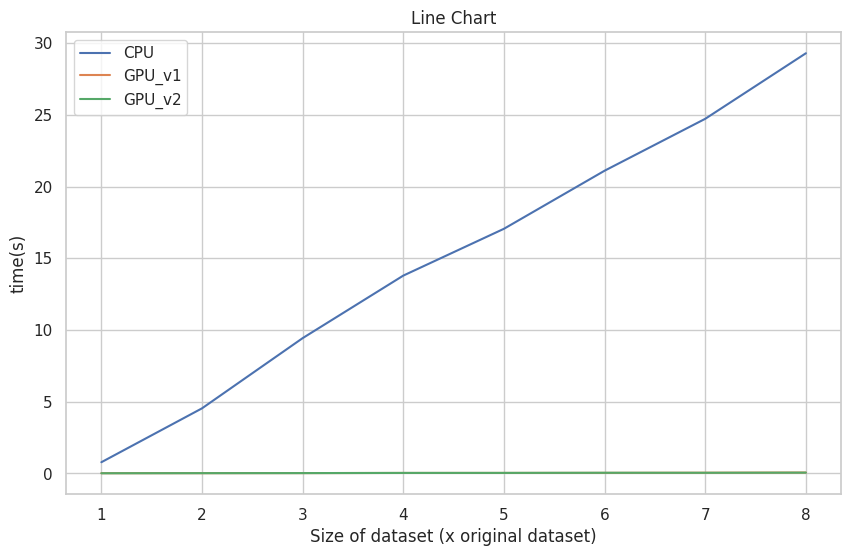

In [87]:
y_arr = [CPU_distance_runtimes, GPUv1_distance_runtimes, GPUv2_distance_runtimes]
y_name = ["CPU", "GPU_v1", "GPU_v2"]
plot_line_chart(x_values, y_arr, y_name, "Size of dataset (x original dataset)",  "time(s)", "Line Chart")

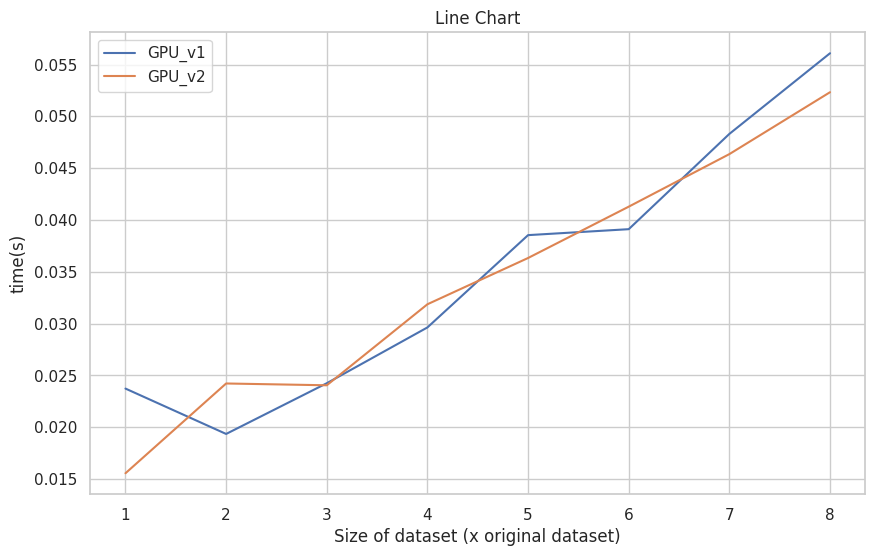

In [106]:
y_arr = [GPUv1_distance_runtimes, GPUv2_distance_runtimes]
y_name = ["GPU_v1", "GPU_v2"]
plot_line_chart(x_values, y_arr, y_name, "Size of dataset (x original dataset)",  "time(s)", "Line Chart")

***Nhận xét***
- Thời gian của các hàm tính khoảng cách đều tăng theo kích thước của dataset
- Thời gian thực thi của GPU sử dụng share memory có cải thiện so với không sử dụng, tuy nhiên kết quả không quá rõ rệt

### Find min

In [69]:
# Array runtime of GPU
CPUv1_min_runtimes = []
for i in range(len(res)):
  CPUv1_min_runtimes.append(apply_function(get_nearest_centroid_cpu_ver1, distances_for_min[i]))
  print(CPUv1_min_runtimes)

[0.0004523220000010042]
[0.0004523220000010042, 0.003012322999893513]
[0.0004523220000010042, 0.003012322999893513, 0.0027121660000375414]
[0.0004523220000010042, 0.003012322999893513, 0.0027121660000375414, 0.004833174999930634]
[0.0004523220000010042, 0.003012322999893513, 0.0027121660000375414, 0.004833174999930634, 0.004236606999711512]
[0.0004523220000010042, 0.003012322999893513, 0.0027121660000375414, 0.004833174999930634, 0.004236606999711512, 0.004971008000211441]
[0.0004523220000010042, 0.003012322999893513, 0.0027121660000375414, 0.004833174999930634, 0.004236606999711512, 0.004971008000211441, 0.0057601450002948695]
[0.0004523220000010042, 0.003012322999893513, 0.0027121660000375414, 0.004833174999930634, 0.004236606999711512, 0.004971008000211441, 0.0057601450002948695, 0.00644402700027058]


In [70]:
# Array runtime of GPU
CPUv2_min_runtimes = []
for i in range(len(res)):
  CPUv2_min_runtimes.append(apply_function(get_nearest_centroid_cpu_ver2, distances_for_min[i]))
  print(CPUv2_min_runtimes)

[0.04154789600033837]
[0.04154789600033837, 0.1614775739999459]
[0.04154789600033837, 0.1614775739999459, 0.29889226299974325]
[0.04154789600033837, 0.1614775739999459, 0.29889226299974325, 0.43374090499992235]
[0.04154789600033837, 0.1614775739999459, 0.29889226299974325, 0.43374090499992235, 0.6018152169999667]
[0.04154789600033837, 0.1614775739999459, 0.29889226299974325, 0.43374090499992235, 0.6018152169999667, 0.7150486780001302]
[0.04154789600033837, 0.1614775739999459, 0.29889226299974325, 0.43374090499992235, 0.6018152169999667, 0.7150486780001302, 0.8238658880000003]
[0.04154789600033837, 0.1614775739999459, 0.29889226299974325, 0.43374090499992235, 0.6018152169999667, 0.7150486780001302, 0.8238658880000003, 1.2420424619999721]


In [111]:
# Array runtime of GPU
GPU_min_runtimes = []
for i in range(len(res)):
  GPU_min_runtimes.append(apply_function(get_nearest_centroid_gpu, distances_for_min[i]))
  print(GPU_min_runtimes)

[0.005023848000746511]
[0.005023848000746511, 0.0037626590001309523]
[0.005023848000746511, 0.0037626590001309523, 0.004927066999698582]
[0.005023848000746511, 0.0037626590001309523, 0.004927066999698582, 0.006268873999943025]
[0.005023848000746511, 0.0037626590001309523, 0.004927066999698582, 0.006268873999943025, 0.014140990000669262]
[0.005023848000746511, 0.0037626590001309523, 0.004927066999698582, 0.006268873999943025, 0.014140990000669262, 0.009185504000015499]
[0.005023848000746511, 0.0037626590001309523, 0.004927066999698582, 0.006268873999943025, 0.014140990000669262, 0.009185504000015499, 0.010304207000444876]
[0.005023848000746511, 0.0037626590001309523, 0.004927066999698582, 0.006268873999943025, 0.014140990000669262, 0.009185504000015499, 0.010304207000444876, 0.015714088000095217]


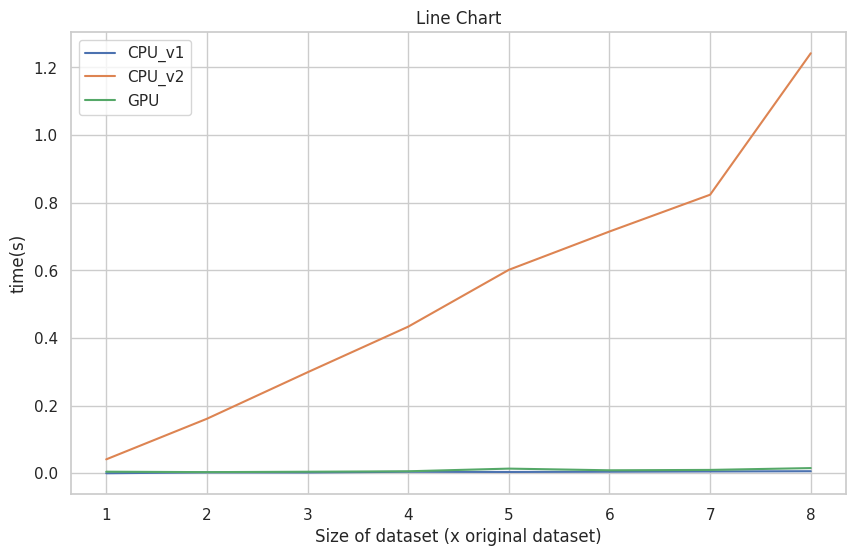

In [112]:
y_arr = [CPUv1_min_runtimes, CPUv2_min_runtimes, GPU_min_runtimes]
y_name = ["CPU_v1", "CPU_v2", "GPU"]
plot_line_chart(x_values, y_arr, y_name, "Size of dataset (x original dataset)",  "time(s)", "Line Chart")

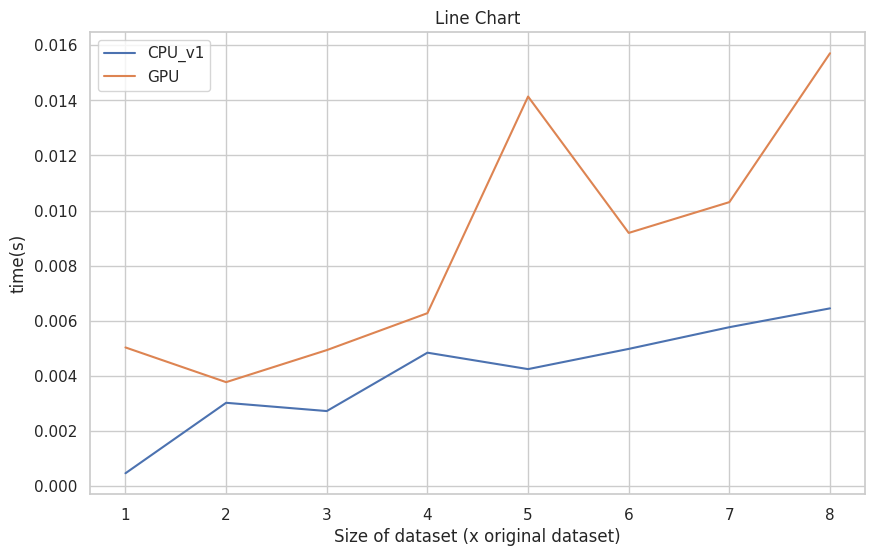

In [113]:
y_arr = [CPUv1_min_runtimes, GPU_min_runtimes]
y_name = ["CPU_v1", "GPU"]
plot_line_chart(x_values, y_arr, y_name, "Size of dataset (x original dataset)",  "time(s)", "Line Chart")

***Nhận xét***
- Thời gian của các hàm tính khoảng cách đều tăng theo kích thước của dataset
- Khi so sánh với tìm min sử dụng numpy, hàm chạy bằng cuda có kết quả lâu hơn và kém ổn định hơn

### Kmean

In [63]:
# Array runtime of GPU
GPU_v1_runtimes = []
for i in range(len(res)):
  GPU_v1_runtimes.append(apply_function(kmean_gpu_v1, res[i], device_datas[i], centroids[i]))
  print(GPU_v1_runtimes)

[0.6933514129996183]
[0.6933514129996183, 0.9181449610000527]
[0.6933514129996183, 0.9181449610000527, 1.994452205000016]
[0.6933514129996183, 0.9181449610000527, 1.994452205000016, 2.35202719300014]
[0.6933514129996183, 0.9181449610000527, 1.994452205000016, 2.35202719300014, 2.7267417820003175]
[0.6933514129996183, 0.9181449610000527, 1.994452205000016, 2.35202719300014, 2.7267417820003175, 3.211458885999946]
[0.6933514129996183, 0.9181449610000527, 1.994452205000016, 2.35202719300014, 2.7267417820003175, 3.211458885999946, 3.5934961769999063]
[0.6933514129996183, 0.9181449610000527, 1.994452205000016, 2.35202719300014, 2.7267417820003175, 3.211458885999946, 3.5934961769999063, 5.588706569999886]


In [64]:
# Array runtime of GPU
GPU_runtimes = []
for i in range(len(res)):
  GPU_runtimes.append(apply_function(kmean_gpu, res[i], device_datas[i], centroids[i]))
  print(GPU_runtimes)

[0.7641980919997877]
[0.7641980919997877, 0.8977621989997715]
[0.7641980919997877, 0.8977621989997715, 1.9296043849999478]
[0.7641980919997877, 0.8977621989997715, 1.9296043849999478, 2.077715452999655]
[0.7641980919997877, 0.8977621989997715, 1.9296043849999478, 2.077715452999655, 1.9175415820000126]
[0.7641980919997877, 0.8977621989997715, 1.9296043849999478, 2.077715452999655, 1.9175415820000126, 2.936119848999624]
[0.7641980919997877, 0.8977621989997715, 1.9296043849999478, 2.077715452999655, 1.9175415820000126, 2.936119848999624, 3.9357823400000598]
[0.7641980919997877, 0.8977621989997715, 1.9296043849999478, 2.077715452999655, 1.9175415820000126, 2.936119848999624, 3.9357823400000598, 5.196698955999636]


In [66]:
# # Array runtime of CPU
# CPU_runtimes = []
# for i in range(len(res)):
#   runtime = apply_function(kmean_cpu, res[i], centroids[i])
#   CPU_runtimes.append(runtime)
#   print(CPU_runtimes)

In [67]:
from sklearn.cluster import KMeans
def kmean_sklearn(data, init_centroid):
  kmeans = KMeans(n_clusters=20, init=init_centroid, n_init="auto", random_state=42)
  kmeans.fit(data)

sklearn_runtimes = []
for i in range(len(res)):
  runtime = apply_function(kmean_sklearn, res[i], centroids[i])
  sklearn_runtimes.append(runtime)
  print(sklearn_runtimes)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:878: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.init == "k-means++":
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


[0.8502752429999418]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:878: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.init == "k-means++":
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


[0.8502752429999418, 0.5576341150003827]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:878: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.init == "k-means++":
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


[0.8502752429999418, 0.5576341150003827, 1.1124139959997592]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:878: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.init == "k-means++":
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


[0.8502752429999418, 0.5576341150003827, 1.1124139959997592, 0.5302677740000945]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:878: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.init == "k-means++":
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


[0.8502752429999418, 0.5576341150003827, 1.1124139959997592, 0.5302677740000945, 0.7023446620000868]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:878: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.init == "k-means++":
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


[0.8502752429999418, 0.5576341150003827, 1.1124139959997592, 0.5302677740000945, 0.7023446620000868, 0.7681286000001819]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:878: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.init == "k-means++":
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


[0.8502752429999418, 0.5576341150003827, 1.1124139959997592, 0.5302677740000945, 0.7023446620000868, 0.7681286000001819, 1.4700246239999615]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:878: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.init == "k-means++":
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


[0.8502752429999418, 0.5576341150003827, 1.1124139959997592, 0.5302677740000945, 0.7023446620000868, 0.7681286000001819, 1.4700246239999615, 2.2543606750000436]


In [ ]:
y_arr = [GPU_v1_runtimes, GPU_runtimes, sklearn_runtimes]
y_name = ["GPU_v1", "GPU_v2", "Sklearn"]
plot_line_chart(x_values, y_arr, y_name, "Size of dataset (x original dataset)",  "time(s)", "Line Chart")

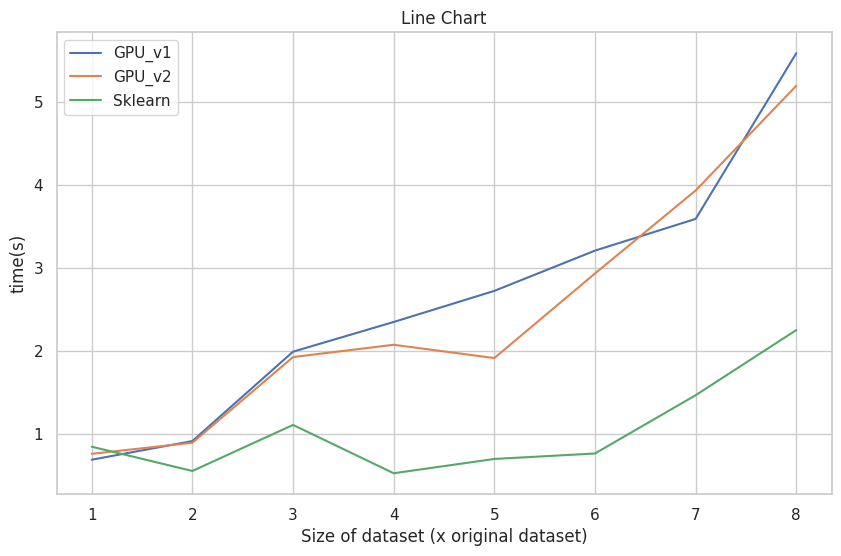

In [74]:

y_arr = [GPU_v1_runtimes, GPU_runtimes, sklearn_runtimes]
y_name = ["GPU_v1", "GPU_v2", "Sklearn"]
plot_line_chart(x_values, y_arr, y_name, "Size of dataset (x original dataset)",  "time(s)", "Line Chart")

***Nhận xét***
- Kết quả cho thấy GPU hoạt động khá tốt và nhanh hơn 1 chút ở dataset gốc khi so với sklearn.
- Tuy nhiên với dataset lớn hơn, sklearn lại ổn định hơn và cho ra kết quả tốt hơn
- Nhìn chung kết quả của GPU ver2 - có sử dụng share memory tương đối khả quan khi so với version 1